Informationen aus https://docs.ultralytics.com/de/usage/python/.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from functions.dataloader import CocoDetDataset, collate_fn
from torch.utils.data import DataLoader

ROOT = "../final_dataset"  
 
train_ds = CocoDetDataset(f"{ROOT}/annotations/instances_train.json", f"{ROOT}/images/train", resize_short=640, augment = True)
val_ds   = CocoDetDataset(f"{ROOT}/annotations/instances_val.json",   f"{ROOT}/images/val",   resize_short=640)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)



/home/gast/Khanh/miniforge3/envs/torchvision_gpu_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gast/Khanh/miniforge3/envs/torchvision_gpu_env/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/gast/Khanh/Repositories/ranscht_detection/functions/transforms.py:21: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 30), p=0.3),


In [3]:
import torch

print("cuda.is_available:", torch.cuda.is_available())
print("torch.version.cuda:", getattr(torch.version, "cuda", None))
print("torch.version:", torch.__version__)
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))

cuda.is_available: True
torch.version.cuda: 12.1
torch.version: 2.2.2
device: NVIDIA GeForce RTX 4090


In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Lade vortrainiertes Modell
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT").to(device)
#Entscheidet für jede Region, welche Klasse und wo sich das Objekt befindet
in_feats = model.roi_heads.box_predictor.cls_score.in_features
# Ersetze den Kopf des Modells durch einen neuen, der die richtige Anzahl an Klassen hat + Hintergrundklasse
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, 2)
model = model.to(device)


In [5]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import time

# Adam-Optimierers mit Weight Decay
# Fügt einen kleinen Strafterm hinzu, der große Gewichtswerte im Modell bestraft
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Mixed Precision Training, normalerweise 32-Bit Fließkommazahlen (float32) verwendet, aber hier teilweise 16-Bit (float16)
# Spart Speicher und kann die Geschwindigkeit erhöhen, besonders auf neueren GPUs
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

EPOCHS = 100
model.train()

loss_per_epoch = []
best_loss = float("inf")  
best_path = "models/model_best.pth"

for epoch in range(EPOCHS):
    total = 0.0
    n_steps = 0
    start = time.time()

    # enumerate() liefert Index mit
    # tqdm() zeigt Fortschrittsbalken an
    for i, (imgs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        # Alle Bilder im Batch auf GPU schieben
        imgs = [im.to(device) for im in imgs]
        # Alle Targets im Batch auf GPU schieben
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
        # Gradienten aller Modellparameter auf null zurücksetzen
        optimizer.zero_grad(set_to_none=True)
        # Automatic Mixed Precision (AMP) Modus
        # autocast() entscheidet automatisch, welche Operationen in float16 und welche in float32
        
        # Vorwärtsdurchlauf: Modell gibt ein Dictionary mit verschiedenen Verlusten zurück
        loss_dict = model(imgs, targets)
         # Gesamten Verlust berechnen
        loss = sum(loss_dict.values())
        # Backward-Pass mit skaliertem Verlust
        loss.backward()
        # Modellparameter aktualisieren
        optimizer.step()
        
        total += loss.item()
        n_steps += 1
    
    epoch_loss = total / n_steps
    loss_per_epoch.append(epoch_loss)

    dur = time.time() - start
    print(f"Epoch {epoch+1}/{EPOCHS} - train loss: {epoch_loss:.4f} ({dur:.1f}s)")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), best_path)
        print(f"[INFO] Saved new best model with loss {best_loss:.4f}")



Epoch 1/100: 100%|██████████| 42/42 [00:10<00:00,  4.20it/s]


Epoch 1/100 - train loss: 0.6894 (10.0s)
[INFO] Saved new best model with loss 0.6894


Epoch 2/100: 100%|██████████| 42/42 [00:09<00:00,  4.65it/s]


Epoch 2/100 - train loss: 0.4206 (9.1s)
[INFO] Saved new best model with loss 0.4206


Epoch 3/100: 100%|██████████| 42/42 [00:09<00:00,  4.42it/s]


Epoch 3/100 - train loss: 0.3938 (9.5s)
[INFO] Saved new best model with loss 0.3938


Epoch 4/100: 100%|██████████| 42/42 [00:09<00:00,  4.43it/s]


Epoch 4/100 - train loss: 0.3620 (9.5s)
[INFO] Saved new best model with loss 0.3620


Epoch 5/100: 100%|██████████| 42/42 [00:08<00:00,  4.71it/s]


Epoch 5/100 - train loss: 0.3674 (9.0s)


Epoch 6/100: 100%|██████████| 42/42 [00:09<00:00,  4.62it/s]


Epoch 6/100 - train loss: 0.3221 (9.1s)
[INFO] Saved new best model with loss 0.3221


Epoch 7/100: 100%|██████████| 42/42 [00:09<00:00,  4.56it/s]


Epoch 7/100 - train loss: 0.3240 (9.3s)


Epoch 8/100: 100%|██████████| 42/42 [00:09<00:00,  4.54it/s]


Epoch 8/100 - train loss: 0.3200 (9.3s)
[INFO] Saved new best model with loss 0.3200


Epoch 9/100: 100%|██████████| 42/42 [00:09<00:00,  4.56it/s]


Epoch 9/100 - train loss: 0.3215 (9.3s)


Epoch 10/100: 100%|██████████| 42/42 [00:09<00:00,  4.62it/s]


Epoch 10/100 - train loss: 0.3110 (9.1s)
[INFO] Saved new best model with loss 0.3110


Epoch 11/100: 100%|██████████| 42/42 [00:08<00:00,  4.73it/s]


Epoch 11/100 - train loss: 0.2797 (8.9s)
[INFO] Saved new best model with loss 0.2797


Epoch 12/100: 100%|██████████| 42/42 [00:09<00:00,  4.57it/s]


Epoch 12/100 - train loss: 0.3198 (9.2s)


Epoch 13/100: 100%|██████████| 42/42 [00:08<00:00,  4.67it/s]


Epoch 13/100 - train loss: 0.3433 (9.0s)


Epoch 14/100: 100%|██████████| 42/42 [00:09<00:00,  4.48it/s]


Epoch 14/100 - train loss: 0.2866 (9.4s)


Epoch 15/100: 100%|██████████| 42/42 [00:09<00:00,  4.64it/s]


Epoch 15/100 - train loss: 0.2977 (9.1s)


Epoch 16/100: 100%|██████████| 42/42 [00:08<00:00,  4.76it/s]


Epoch 16/100 - train loss: 0.2833 (8.9s)


Epoch 17/100: 100%|██████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 17/100 - train loss: 0.2798 (9.3s)


Epoch 18/100: 100%|██████████| 42/42 [00:09<00:00,  4.66it/s]


Epoch 18/100 - train loss: 0.2954 (9.0s)


Epoch 19/100: 100%|██████████| 42/42 [00:09<00:00,  4.63it/s]


Epoch 19/100 - train loss: 0.2709 (9.1s)
[INFO] Saved new best model with loss 0.2709


Epoch 20/100: 100%|██████████| 42/42 [00:09<00:00,  4.43it/s]


Epoch 20/100 - train loss: 0.2700 (9.5s)
[INFO] Saved new best model with loss 0.2700


Epoch 21/100: 100%|██████████| 42/42 [00:09<00:00,  4.50it/s]


Epoch 21/100 - train loss: 0.2971 (9.4s)


Epoch 22/100: 100%|██████████| 42/42 [00:09<00:00,  4.67it/s]


Epoch 22/100 - train loss: 0.2660 (9.0s)
[INFO] Saved new best model with loss 0.2660


Epoch 23/100: 100%|██████████| 42/42 [00:08<00:00,  4.71it/s]


Epoch 23/100 - train loss: 0.2767 (9.0s)


Epoch 24/100: 100%|██████████| 42/42 [00:09<00:00,  4.62it/s]


Epoch 24/100 - train loss: 0.2516 (9.1s)
[INFO] Saved new best model with loss 0.2516


Epoch 25/100: 100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


Epoch 25/100 - train loss: 0.2553 (9.4s)


Epoch 26/100: 100%|██████████| 42/42 [00:09<00:00,  4.58it/s]


Epoch 26/100 - train loss: 0.2251 (9.2s)
[INFO] Saved new best model with loss 0.2251


Epoch 27/100: 100%|██████████| 42/42 [00:09<00:00,  4.50it/s]


Epoch 27/100 - train loss: 0.2668 (9.4s)


Epoch 28/100: 100%|██████████| 42/42 [00:09<00:00,  4.46it/s]


Epoch 28/100 - train loss: 0.2814 (9.5s)


Epoch 29/100: 100%|██████████| 42/42 [00:09<00:00,  4.51it/s]


Epoch 29/100 - train loss: 0.2501 (9.3s)


Epoch 30/100: 100%|██████████| 42/42 [00:09<00:00,  4.56it/s]


Epoch 30/100 - train loss: 0.2352 (9.2s)


Epoch 31/100: 100%|██████████| 42/42 [00:09<00:00,  4.45it/s]


Epoch 31/100 - train loss: 0.2552 (9.5s)


Epoch 32/100: 100%|██████████| 42/42 [00:09<00:00,  4.65it/s]


Epoch 32/100 - train loss: 0.2490 (9.1s)


Epoch 33/100: 100%|██████████| 42/42 [00:09<00:00,  4.65it/s]


Epoch 33/100 - train loss: 0.2466 (9.1s)


Epoch 34/100: 100%|██████████| 42/42 [00:08<00:00,  4.76it/s]


Epoch 34/100 - train loss: 0.2241 (8.9s)
[INFO] Saved new best model with loss 0.2241


Epoch 35/100: 100%|██████████| 42/42 [00:08<00:00,  4.86it/s]


Epoch 35/100 - train loss: 0.2445 (8.7s)


Epoch 36/100: 100%|██████████| 42/42 [00:09<00:00,  4.55it/s]


Epoch 36/100 - train loss: 0.2473 (9.3s)


Epoch 37/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 37/100 - train loss: 0.2417 (9.2s)


Epoch 38/100: 100%|██████████| 42/42 [00:08<00:00,  4.68it/s]


Epoch 38/100 - train loss: 0.2408 (9.0s)


Epoch 39/100: 100%|██████████| 42/42 [00:09<00:00,  4.54it/s]


Epoch 39/100 - train loss: 0.2484 (9.3s)


Epoch 40/100: 100%|██████████| 42/42 [00:08<00:00,  4.68it/s]


Epoch 40/100 - train loss: 0.2392 (9.0s)


Epoch 41/100: 100%|██████████| 42/42 [00:09<00:00,  4.59it/s]


Epoch 41/100 - train loss: 0.2255 (9.2s)


Epoch 42/100: 100%|██████████| 42/42 [00:09<00:00,  4.55it/s]


Epoch 42/100 - train loss: 0.2429 (9.3s)


Epoch 43/100: 100%|██████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 43/100 - train loss: 0.2394 (9.3s)


Epoch 44/100: 100%|██████████| 42/42 [00:09<00:00,  4.55it/s]


Epoch 44/100 - train loss: 0.2346 (9.3s)


Epoch 45/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 45/100 - train loss: 0.2803 (9.2s)


Epoch 46/100: 100%|██████████| 42/42 [00:09<00:00,  4.54it/s]


Epoch 46/100 - train loss: 0.2605 (9.3s)


Epoch 47/100: 100%|██████████| 42/42 [00:09<00:00,  4.44it/s]


Epoch 47/100 - train loss: 0.2428 (9.5s)


Epoch 48/100: 100%|██████████| 42/42 [00:09<00:00,  4.54it/s]


Epoch 48/100 - train loss: 0.2211 (9.3s)
[INFO] Saved new best model with loss 0.2211


Epoch 49/100: 100%|██████████| 42/42 [00:09<00:00,  4.67it/s]


Epoch 49/100 - train loss: 0.2392 (9.0s)


Epoch 50/100: 100%|██████████| 42/42 [00:09<00:00,  4.58it/s]


Epoch 50/100 - train loss: 0.2342 (9.2s)


Epoch 51/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 51/100 - train loss: 0.2593 (9.2s)


Epoch 52/100: 100%|██████████| 42/42 [00:08<00:00,  4.72it/s]


Epoch 52/100 - train loss: 0.2398 (8.9s)


Epoch 53/100: 100%|██████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 53/100 - train loss: 0.2415 (9.3s)


Epoch 54/100: 100%|██████████| 42/42 [00:09<00:00,  4.45it/s]


Epoch 54/100 - train loss: 0.2285 (9.5s)


Epoch 55/100: 100%|██████████| 42/42 [00:09<00:00,  4.65it/s]


Epoch 55/100 - train loss: 0.2235 (9.1s)


Epoch 56/100: 100%|██████████| 42/42 [00:08<00:00,  4.77it/s]


Epoch 56/100 - train loss: 0.2369 (8.8s)


Epoch 57/100: 100%|██████████| 42/42 [00:09<00:00,  4.58it/s]


Epoch 57/100 - train loss: 0.2275 (9.2s)


Epoch 58/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 58/100 - train loss: 0.2100 (9.2s)
[INFO] Saved new best model with loss 0.2100


Epoch 59/100: 100%|██████████| 42/42 [00:08<00:00,  4.81it/s]


Epoch 59/100 - train loss: 0.2277 (8.8s)


Epoch 60/100: 100%|██████████| 42/42 [00:08<00:00,  4.77it/s]


Epoch 60/100 - train loss: 0.2177 (8.8s)


Epoch 61/100: 100%|██████████| 42/42 [00:09<00:00,  4.65it/s]


Epoch 61/100 - train loss: 0.2110 (9.1s)


Epoch 62/100: 100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


Epoch 62/100 - train loss: 0.2388 (9.4s)


Epoch 63/100: 100%|██████████| 42/42 [00:08<00:00,  4.73it/s]


Epoch 63/100 - train loss: 0.2435 (8.9s)


Epoch 64/100: 100%|██████████| 42/42 [00:09<00:00,  4.52it/s]


Epoch 64/100 - train loss: 0.2217 (9.3s)


Epoch 65/100: 100%|██████████| 42/42 [00:08<00:00,  4.78it/s]


Epoch 65/100 - train loss: 0.2208 (8.8s)


Epoch 66/100: 100%|██████████| 42/42 [00:09<00:00,  4.61it/s]


Epoch 66/100 - train loss: 0.2250 (9.2s)


Epoch 67/100: 100%|██████████| 42/42 [00:09<00:00,  4.67it/s]


Epoch 67/100 - train loss: 0.2416 (9.0s)


Epoch 68/100: 100%|██████████| 42/42 [00:08<00:00,  4.75it/s]


Epoch 68/100 - train loss: 0.2206 (8.9s)


Epoch 69/100: 100%|██████████| 42/42 [00:08<00:00,  4.68it/s]


Epoch 69/100 - train loss: 0.2163 (9.0s)


Epoch 70/100: 100%|██████████| 42/42 [00:09<00:00,  4.63it/s]


Epoch 70/100 - train loss: 0.2342 (9.1s)


Epoch 71/100: 100%|██████████| 42/42 [00:09<00:00,  4.64it/s]


Epoch 71/100 - train loss: 0.2261 (9.1s)


Epoch 72/100: 100%|██████████| 42/42 [00:09<00:00,  4.42it/s]


Epoch 72/100 - train loss: 0.2468 (9.5s)


Epoch 73/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 73/100 - train loss: 0.2182 (9.2s)


Epoch 74/100: 100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


Epoch 74/100 - train loss: 0.2059 (9.4s)
[INFO] Saved new best model with loss 0.2059


Epoch 75/100: 100%|██████████| 42/42 [00:09<00:00,  4.37it/s]


Epoch 75/100 - train loss: 0.2020 (9.7s)
[INFO] Saved new best model with loss 0.2020


Epoch 76/100: 100%|██████████| 42/42 [00:09<00:00,  4.47it/s]


Epoch 76/100 - train loss: 0.2108 (9.4s)


Epoch 77/100: 100%|██████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 77/100 - train loss: 0.2137 (9.3s)


Epoch 78/100: 100%|██████████| 42/42 [00:09<00:00,  4.52it/s]


Epoch 78/100 - train loss: 0.2135 (9.3s)


Epoch 79/100: 100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


Epoch 79/100 - train loss: 0.1981 (9.4s)
[INFO] Saved new best model with loss 0.1981


Epoch 80/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 80/100 - train loss: 0.2116 (9.2s)


Epoch 81/100: 100%|██████████| 42/42 [00:09<00:00,  4.47it/s]


Epoch 81/100 - train loss: 0.2186 (9.4s)


Epoch 82/100: 100%|██████████| 42/42 [00:09<00:00,  4.48it/s]


Epoch 82/100 - train loss: 0.2181 (9.4s)


Epoch 83/100: 100%|██████████| 42/42 [00:09<00:00,  4.48it/s]


Epoch 83/100 - train loss: 0.2015 (9.4s)


Epoch 84/100: 100%|██████████| 42/42 [00:09<00:00,  4.44it/s]


Epoch 84/100 - train loss: 0.2277 (9.5s)


Epoch 85/100: 100%|██████████| 42/42 [00:09<00:00,  4.42it/s]


Epoch 85/100 - train loss: 0.2238 (9.5s)


Epoch 86/100: 100%|██████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 86/100 - train loss: 0.2170 (9.3s)


Epoch 87/100: 100%|██████████| 42/42 [00:09<00:00,  4.58it/s]


Epoch 87/100 - train loss: 0.2176 (9.2s)


Epoch 88/100: 100%|██████████| 42/42 [00:08<00:00,  4.76it/s]


Epoch 88/100 - train loss: 0.2109 (8.9s)


Epoch 89/100: 100%|██████████| 42/42 [00:08<00:00,  4.74it/s]


Epoch 89/100 - train loss: 0.2101 (8.9s)


Epoch 90/100: 100%|██████████| 42/42 [00:09<00:00,  4.54it/s]


Epoch 90/100 - train loss: 0.1995 (9.3s)


Epoch 91/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 91/100 - train loss: 0.2018 (9.2s)


Epoch 92/100: 100%|██████████| 42/42 [00:09<00:00,  4.42it/s]


Epoch 92/100 - train loss: 0.2051 (9.6s)


Epoch 93/100: 100%|██████████| 42/42 [00:09<00:00,  4.40it/s]


Epoch 93/100 - train loss: 0.1850 (9.6s)
[INFO] Saved new best model with loss 0.1850


Epoch 94/100: 100%|██████████| 42/42 [00:09<00:00,  4.66it/s]


Epoch 94/100 - train loss: 0.2194 (9.1s)


Epoch 95/100: 100%|██████████| 42/42 [00:08<00:00,  4.70it/s]


Epoch 95/100 - train loss: 0.2022 (9.0s)


Epoch 96/100: 100%|██████████| 42/42 [00:09<00:00,  4.62it/s]


Epoch 96/100 - train loss: 0.1931 (9.1s)


Epoch 97/100: 100%|██████████| 42/42 [00:08<00:00,  4.78it/s]


Epoch 97/100 - train loss: 0.1976 (8.8s)


Epoch 98/100: 100%|██████████| 42/42 [00:08<00:00,  4.68it/s]


Epoch 98/100 - train loss: 0.1858 (9.0s)


Epoch 99/100: 100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


Epoch 99/100 - train loss: 0.2052 (9.2s)


Epoch 100/100: 100%|██████████| 42/42 [00:09<00:00,  4.57it/s]

Epoch 100/100 - train loss: 0.1872 (9.2s)


Loss anzeigen

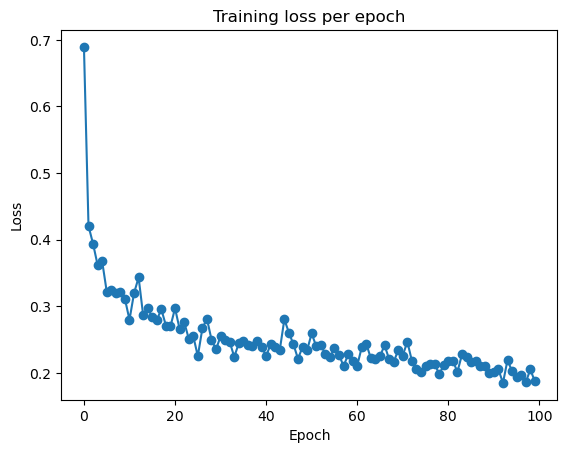

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_per_epoch, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss per epoch")
plt.show()
